Формат файла: login tid Microtasks assigned_ts tclosed_ts.

Пояснение к формату: login — логин асессора; tid — id оцениваемого задания (task id); Microtasks – количество микрозаданий в одном задании; assigned_ts — время резервирования системой задания для асессора; closed_ts — точное время завершения работы над заданием; разделитель — табуляция \t.

Задание может состоять из одного или несколько микрозаданий. Время резервирования задания (assigned_ts) указывает на тот момент, когда система назначила определенного асессора исполнителем этого задания. Этот момент может совпадать с временем начала работы асессора над заданием, а может и не совпадать (асессор может отойти выпить чаю, а потом приступить к заданию, асессор может выполнять предыдущее задание, в то время как за ним зарезервированы новые).

Предположим, что асессор за 30 секунд своего рабочего времени получает N рублей.

Какую оплату вы считаете справедливой для выполнения асессором одного микрозадания из этого файла? Опишите подробно все этапы вашего решения.

### Импорт модулей

In [47]:
import pandas as pd
import datetime as dt
import numpy as np
from math import ceil

pd.options.mode.chained_assignment = None

### Функции

In [4]:
def iqr_test(column, lim_a, lim_b, bins, df=df, hist=True):
    """
    Функция определения медианы, квантилей 25%/75% и 
    границы выбросов для данного сталбцы 
    lim_a lim_b - пределы для построенния гистограммы
    """
    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), 
          '75-й перцентиль: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}]."
          .format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    if hist:
        df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].\
        hist(bins=bins, range=(lim_a, lim_b), label='IQR')
        
def list_create(row):
    row['counts'] = np.ones(row['Microtasks'])
    return row

In [3]:
df = pd.read_csv('data_task4_old.txt', delimiter= '\t')

In [5]:
df.head(3)

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10


Преобразуем временные столбцы в формат datetime

In [6]:
df['assigned_ts'] = pd.to_datetime(df.assigned_ts, format='%Y-%m-%d %H:%M:%S')

In [7]:
df['closed_ts'] = pd.to_datetime(df.closed_ts, format='%Y-%m-%d %H:%M:%S')

In [8]:
df['Microtasks'] = df['Microtasks'].astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   login        701827 non-null  object        
 1   tid          701827 non-null  float64       
 2   Microtasks   701827 non-null  int32         
 3   assigned_ts  701827 non-null  datetime64[ns]
 4   closed_ts    701827 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), object(1)
memory usage: 24.1+ MB


Для начала посмотрим время работы над заданиями. Создадим столбец с длительностью 

In [10]:
df['duration'] = abs(df['closed_ts'] - df['assigned_ts']) # иногда старт и финиш перепутаны

In [11]:
df = df.drop_duplicates() # часть строк дублируется полностью

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tid,680037,1.88568e+08,1.3678e+07,1.13959e+08,1.90685e+08,1.93564e+08,1.96375e+08,1.98576e+08
Microtasks,680037,3.24528,3.64697,1,1,2,4,50
duration,680037,0 days 00:31:24.007527,0 days 03:02:19.455662,0 days 00:00:03,0 days 00:01:07,0 days 00:02:37,0 days 00:07:15,23 days 15:32:58


In [13]:
df.sort_values(by='duration')

,login,tid,Microtasks,assigned_ts,closed_ts,duration
640216,login699,195931108.0,1,2017-05-16 14:15:31,2017-05-16 14:15:34,0 days 00:00:03
640206,login699,195930258.0,1,2017-05-16 14:14:42,2017-05-16 14:14:45,0 days 00:00:03
640201,login699,195931178.0,1,2017-05-16 14:14:29,2017-05-16 14:14:32,0 days 00:00:03
640204,login699,195930544.0,1,2017-05-16 14:14:37,2017-05-16 14:14:40,0 days 00:00:03
521874,login564,195937488.0,1,2017-05-16 14:07:33,2017-05-16 14:07:37,0 days 00:00:04
...,...,...,...,...,...,...
603630,login657,195642338.0,1,2017-05-17 06:41:20,2017-05-29 17:03:56,12 days 10:22:36
291803,login300,185713868.0,15,2017-05-03 06:32:56,2017-05-22 16:26:19,19 days 09:53:23
291801,login300,189300182.0,13,2017-04-30 06:32:42,2017-05-22 16:23:44,22 days 09:51:02
291798,login300,185713854.0,17,2017-04-29 06:33:09,2017-05-22 16:21:41,23 days 09:48:32


У нас нет данных о том сколько длилось каждое конкретное задание, можно посчитать среднее для каждого микротаска 

In [14]:
df['time_task'] = df['duration'] / df['Microtasks']

Т.к. у нас расчет ведется по минутам (вернее 30 сек) , преобразуем столбец в числовой формат (минуты)

In [15]:
df['time_task'] = df['time_task'] / np.timedelta64(1, 'm')

In [16]:
df.head(3)

,login,tid,Microtasks,assigned_ts,closed_ts,duration,time_task
0,login0,190563850.0,4,2017-04-20 12:09:39,2017-04-20 13:13:01,01:03:22,15.841667
1,login0,190561754.0,1,2017-04-20 12:10:30,2017-04-20 12:28:29,00:17:59,17.983333
2,login0,190565906.0,4,2017-04-20 12:21:31,2017-04-20 13:30:10,01:08:39,17.162500


In [17]:
df.sort_values(by='time_task')

,login,tid,Microtasks,assigned_ts,closed_ts,duration,time_task
151272,login139,196400390.0,13,2017-05-20 17:20:02,2017-05-20 17:20:25,0 days 00:00:23,0.029487
153221,login139,198396915.0,42,2017-06-01 01:34:21,2017-06-01 01:35:38,0 days 00:01:17,0.030556
315281,login328,168095766.0,9,2017-05-11 16:06:02,2017-05-11 16:06:19,0 days 00:00:17,0.031481
474137,login517,192276632.0,8,2017-04-27 08:40:29,2017-04-27 08:40:45,0 days 00:00:16,0.033333
153207,login139,198396841.0,50,2017-06-01 01:24:08,2017-06-01 01:25:48,0 days 00:01:40,0.033333
...,...,...,...,...,...,...,...
291824,login300,195509762.0,1,2017-05-17 06:39:37,2017-05-23 11:56:24,6 days 05:16:47,8956.783333
291828,login300,195631030.0,1,2017-05-17 06:41:13,2017-05-24 06:57:28,7 days 00:16:15,10096.250000
291826,login300,195582430.0,1,2017-05-17 06:40:29,2017-05-24 06:57:04,7 days 00:16:35,10096.583333
291834,login300,195502918.0,1,2017-05-18 06:35:43,2017-05-25 10:15:40,7 days 03:39:57,10299.950000


Чтобы правильно посчитать среднее и арифмитическое, отклонение и пр. нужно чтобы количество строк в датафрейме совпадало с количеством микротасков. 

In [18]:
df_exploded = df.apply(list_create, axis=1).explode('counts')

In [19]:
df_exploded['time_task'].describe()

count    2.206912e+06
mean     9.675622e+00
std      5.142164e+01
min      2.948718e-02
25%      5.069444e-01
50%      1.033333e+00
75%      2.698333e+00
max      1.790260e+04
Name: time_task, dtype: float64

Среднее время задания более 9,5 минут, медиана при этом только 1 минута. Нужно убрать выбросы.

25-й перцентиль: 0.5069444444333333, 75-й перцентиль: 2.6983333333333333, IQR: 2.1913888888999997,  Границы выбросов: [-2.7801388889166665, 5.985416666683333].


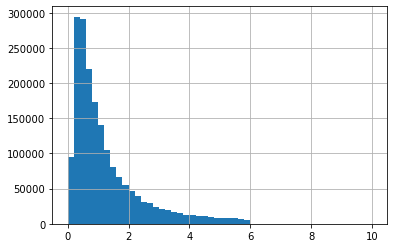

In [20]:
iqr_test('time_task', 0, 10, 50, df_exploded)

Проверим версию с "чаепитием". Сгруппируем по количеству микротасков и посмотрим как меняется среднее время выполнения задания. 

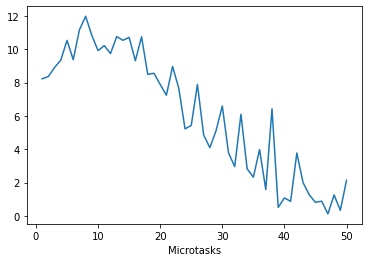

In [21]:
df_exploded.groupby('Microtasks')['time_task'].mean().plot();

Виден "отложенный" старт в микротасках с малым количеством.

### Очистка данных  
Вначале убираем выбросы, в данном случае микротаски с временем исполнение больше 5.9855 минут  

In [22]:
df_exploded.query('time_task<5.9855').describe()

,tid,Microtasks,duration,time_task
count,1.869835e+06,1.869835e+06,1869835,1.869835e+06
mean,1.827992e+08,7.241779e+00,0 days 00:07:51.942776,1.249382e+00
std,1.610863e+07,6.026939e+00,0 days 00:10:44.809016,1.171324e+00
min,1.139586e+08,1.000000e+00,0 days 00:00:03,2.948718e-02
25%,1.696563e+08,3.000000e+00,0 days 00:02:00,4.500000e-01
50%,1.910433e+08,7.000000e+00,0 days 00:04:23,8.333333e-01
75%,1.956320e+08,1.000000e+01,0 days 00:09:25,1.602381e+00
max,1.985758e+08,5.000000e+01,0 days 04:03:13,5.983333e+00


Что выполнить проще один микротаск на 30-50 заданий или несколько маленьких ?   
Сгруппируем на 10 частей (каждые 5) по количеству заданий. 

In [23]:
df_exploded.query('time_task<5.9855').groupby(df.Microtasks // 5)['time_task'].median()

Microtasks
0     1.050000
1     0.795833
2     0.695833
3     0.613725
4     0.515972
5     0.398000
6     0.458333
7     0.312500
8     0.321212
9     0.248148
10    0.258167
Name: time_task, dtype: float64

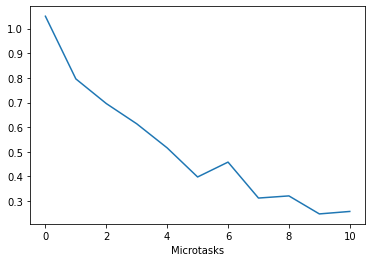

In [24]:
df_exploded.query('time_task<5.9855').groupby(df.Microtasks//5)['time_task'].median().plot();

Каждое задание содержит от 1 до 50 микротасков. Задания где один микротаск выполняются в среднем (по медиане) около одной минуты. Когда количество микротасков приближается к 45-50 время выполнения приближается к 15 секунд. Чтобы было справедливо, необходимо заложить минимальную оценка работы (предположим N/2 за каждый микротакс) + ставку за количество микротасков в задании. Изначально распределение было похоже на логнормальное, возможно это график экспоненты. 

In [31]:
df_exploded['duration_min'] = df_exploded['time_task'] * df['Microtasks']

In [32]:
mt = df_exploded.groupby(df.Microtasks)['duration_min'].median().reset_index()

Можно предложить схему в таком виде:  
Базовая ставка за задание = 0,5 минуты
Базовая ставка за микротаск в задании 0,25 минуты  
Бонусная ставка за количество заданий. Чем меньше заданий, тем больше бонус.  
По факту у нас линейная регрессия с виде 0,5 + 0,25*X + еще что-то. 

In [33]:
# Базовая ставка за задание N/2   # базовая ставка за микротаск
mt['base'] = 0.5
mt['base_micro'] = 0.25  

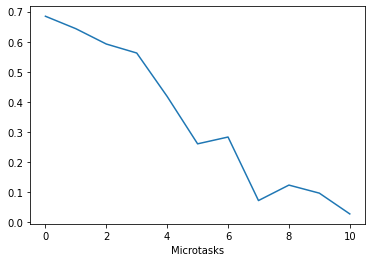

In [34]:
mt['dur_micro'] = mt['base_micro']*mt['Microtasks']  # Нормируем время за количество микротасков
mt['bonus_tm'] = mt['duration_min'] - mt['base'] - mt['dur_micro']
mt['bonus_tm_1mt'] = mt['bonus_tm'] / mt['Microtasks'] # В пересчете на 1 микротаск
mt.groupby(mt.Microtasks//5)['bonus_tm_1mt'].median().plot();

In [35]:
mt.head()

,Microtasks,duration_min,base,base_micro,dur_micro,bonus_tm,bonus_tm_1mt
0,1,1.483333,0.5,0.25,0.25,0.733333,0.733333
1,2,2.416667,0.5,0.25,0.50,1.416667,0.708333
2,3,3.233333,0.5,0.25,0.75,1.983333,0.661111
3,4,4.066667,0.5,0.25,1.00,2.566667,0.641667
4,5,4.966667,0.5,0.25,1.25,3.216667,0.643333


In [36]:
X = np.column_stack((np.ones(50), np.log(mt['Microtasks'])))
y = np.array(mt['bonus_tm'])

In [37]:
koef=np.linalg.inv(X.T@X)@X.T@y
koef

array([0.94283667, 2.120799  ])


Можно привести формулу для к виду уравнения y=a + bx + c$ln$(x), но так будет менее удобно менять ставки.   
Добавляем столбец бонуса = 0,964 - 0,195 $ln(x)$, столбец базовой ставки за задание и столбец базовой ставки за микротаск в наш начальный датафрейм

In [38]:
df['base'] = 0.5 
df['bonus_mct'] = 0.25
df['bonus_counts'] =  np.log(df['Microtasks']) * 2.12

In [39]:
df['total_time'] = df['base'] + df['bonus_mct'] * df['Microtasks'] + df['bonus_counts']

In [40]:
df['time_1tsk'] = df['total_time'] / df['Microtasks']
df['time_1tsk'].describe()

count    680037.000000
mean          0.897300
std           0.199434
min           0.425870
25%           0.750000
50%           0.750000
75%           1.109736
max           1.234736
Name: time_1tsk, dtype: float64

Средние значения чутка подросли, отклонение закономерно стало гораздо меньше. Теперь посчитаем по пользователям, примерную статистику, по заданиям.  

In [43]:
df['duration_min'] = df['time_task'] * df['Microtasks']
users = df.groupby('login')[['duration_min', 'total_time']].mean()

In [44]:
df.groupby('login')['Microtasks'].count().sort_values()

login
login72         1
login282        1
login130        1
login551        1
login752        1
            ...  
login132     7980
login139     9615
login73     11377
login224    11462
login7      13721
Name: Microtasks, Length: 767, dtype: int64

In [45]:
user7 = df[df.login=='login7'][['Microtasks', 'duration_min', 'total_time']]
user7['time_ratio'] = user7['total_time'] / user7['duration_min']
user7.groupby('Microtasks')[['total_time', 'duration_min']].mean()

,total_time,duration_min
Microtasks,,
1,0.750000,2.163811
2,2.469472,3.179466
3,3.579058,4.048546
4,4.438944,5.013700
5,5.162008,6.069365
6,5.798530,6.486393
7,6.375330,11.643860
8,6.908416,8.994444
9,7.408116,9.723692


## Нормирование оплаты
Чтобы нормировать оплату за задания, можно округлить время обработки задания кратно 30 сек (N) и окргулить в большую сторону. 

In [49]:
df['n_count'] = df['total_time'].apply(lambda x: ceil(x/0.5))

# Количество микратасков в задании  и количество "блоков N" равных 30 сек
df.groupby('Microtasks')['n_count'].mean()

Microtasks
1      2
2      5
3      8
4      9
5     11
6     12
7     13
8     14
9     15
10    16
11    17
12    18
13    19
14    20
15    20
16    21
17    22
18    23
19    23
20    24
21    25
22    26
23    26
24    27
25    28
26    28
27    29
28    30
29    30
30    31
31    32
32    32
33    33
34    33
35    34
36    35
37    35
38    36
39    37
40    37
41    38
42    38
43    39
44    40
45    40
46    41
47    41
48    42
49    43
50    43
Name: n_count, dtype: int64